In [2]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
import os

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels

from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.vaep.formula import value
import socceraction.vaep.formula as vaepformula
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
import tqdm
import random

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.formula as vaepformula

from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)


In [3]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
from socceraction.data.wyscout import PublicWyscoutLoader



In [4]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [5]:
comp = [
     #'England'
     #'France',
     'Germany',
     #'Italy',
     #'Spain'
]

In [6]:
##DA qui

In [7]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [8]:
selected_competitions = competitions[(competitions['country_name'] =='Germany')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
4,426,181137,Germany,German first division,male,2017/2018


### Append home and away goals to the game dataset

In [9]:
## Create empty list for DataFrames
dfs_matches = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_matches list
for competition in selected_competitions['country_name']:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)

## Concatenate DataFrames to one DataFrame
df_matches = pd.concat(dfs_matches)
df_matches= df_matches.reset_index()

In [10]:
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    home_score.append(df_matches['teamsData'][i][home_id]['score'])
    away_score.append(df_matches['teamsData'][i][away_id]['score'])


In [11]:
df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

In [12]:
df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181137,2517036,"Bayern M\u00fcnchen - Stuttgart, 1 - 4",426,1,4
1,181137,2517037,"Hoffenheim - Borussia Dortmund, 3 - 1",426,3,1
2,181137,2517038,"Hertha BSC - RB Leipzig, 2 - 6",426,2,6
3,181137,2517039,"Freiburg - Augsburg, 2 - 0",426,2,0
4,181137,2517040,"Schalke 04 - Eintracht Frankfurt, 1 - 0",426,1,0


In [13]:
# Get games from all selected competitions
games = pd.concat([
    wyscout.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])

In [14]:
games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,2517036,426,181137,2018-05-12 13:30:00,34,2444,2445
1,2517037,426,181137,2018-05-12 13:30:00,34,2482,2447
2,2517038,426,181137,2018-05-12 13:30:00,34,2457,2975
3,2517039,426,181137,2018-05-12 13:30:00,34,2453,2481
4,2517040,426,181137,2018-05-12 13:30:00,34,2449,2462


In [15]:
match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

In [16]:
games[["home_team_id", "away_team_id", "game_date","home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,2444,2445,2018-05-12 13:30:00,1,4
1,2482,2447,2018-05-12 13:30:00,3,1
2,2457,2975,2018-05-12 13:30:00,2,6
3,2453,2481,2018-05-12 13:30:00,2,0
4,2449,2462,2018-05-12 13:30:00,1,0
...,...,...,...,...,...
301,2457,2445,2017-08-19 13:30:00,2,0
302,2450,2481,2017-08-19 13:30:00,1,0
303,2460,2455,2017-08-19 13:30:00,0,1
304,2451,2447,2017-08-19 13:30:00,0,3


In [17]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 305
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         306 non-null    int64         
 1   competition_id  306 non-null    int64         
 2   season_id       306 non-null    int64         
 3   game_date       306 non-null    datetime64[ns]
 4   game_day        306 non-null    int64         
 5   home_team_id    306 non-null    int64         
 6   away_team_id    306 non-null    int64         
 7   home_score      306 non-null    int64         
 8   away_score      306 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 23.9 KB


### Convert event to actions

In [18]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Ger"

In [19]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [20]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,2444,Bayern M\u00fcnchen,FC Bayern M\u00fcnchen
1,2445,Stuttgart,VfB Stuttgart 1893
2,2482,Hoffenheim,TSG 1899 Hoffenheim
3,2447,Borussia Dortmund,BV Borussia 09 Dortmund
4,2457,Hertha BSC,Hertha BSC
5,2975,RB Leipzig,Rasen Ballsport Leipzig
6,2453,Freiburg,SC Freiburg
7,2481,Augsburg,FC Augsburg
8,2449,Schalke 04,FC Schalke 04
9,2462,Eintracht Frankfurt,Eintracht Frankfurt


In [21]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.country_name == "Germany") 
                  & (games.home_team_name_short == "Borussia Dortmund")
                  & (games.away_team_name_short== "Schalke 04")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[:5]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
0,2516847,209083443,0,1,3.683304,2447,25867,51.45,34.68,-13.65,8.84,0,0,pass,foot,P. Aubameyang,Borussia Dortmund,BV Borussia 09 Dortmund
1,2516847,209083443,1,1,4.954406,2447,3320,37.80,43.52,0.00,0.00,23,0,receival,foot,N. Şahin,Borussia Dortmund,BV Borussia 09 Dortmund
2,2516847,209083445,2,1,6.225507,2447,3320,37.80,43.52,-10.50,-28.56,0,0,pass,foot,N. Şahin,Borussia Dortmund,BV Borussia 09 Dortmund
3,2516847,209083445,3,1,7.653658,2447,14778,27.30,14.96,0.00,0.00,23,0,receival,foot,Ö. Toprak,Borussia Dortmund,BV Borussia 09 Dortmund
4,2516847,209083467,4,1,9.081809,2447,14778,27.30,14.96,10.50,-11.56,0,0,pass,foot,Ö. Toprak,Borussia Dortmund,BV Borussia 09 Dortmund


2017-11-25 14:30:00, BV Borussia 09 Dortmund - FC Schalke 04 : 4-4 , M. Götze 20'


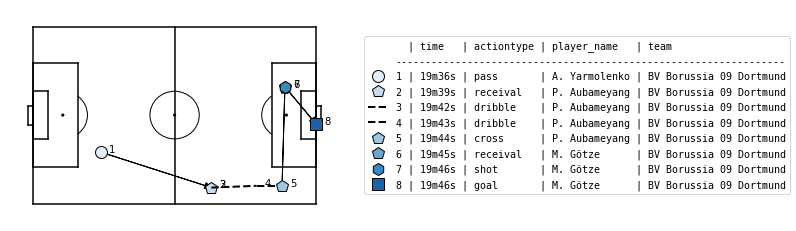

In [22]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][1:2].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

## Compute features and labels

In [23]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [24]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 306


### Compute Probabilities

In [25]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [26]:
# 1. Select feature set X
xfns = [
    #fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 3

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

## Model 

In [27]:
### load model 
import pickle
model = pickle.load(open('trained_model.sav', 'rb'))

In [28]:
#Prediction per tutte le partite
gamesX, gamesY = getXY(games,Xcols)
Y_hat = pd.DataFrame()
for col in gamesY.columns:
    Y_hat[col] = [p[1] for p in model[col].predict_proba(gamesX)]

Selecting label: 100%|██████████| 306/306 [00:04<00:00, 62.38it/s]


In [29]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading actions of each game"):
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 306/306 [00:12<00:00, 25.09it/s]


## VAEP

In [30]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 306


In [31]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"] #Solo azioni
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    ) #Azioni con giocatori/team.
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 306/306 [00:40<00:00,  7.63it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [32]:
#Df with players and roles
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role','currentTeamId']]
Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

df_players = pd.merge(df_players, teams, left_on = 'currentTeamId', right_on = 'team_id').drop(['currentTeamId','team_id','team_name'], axis = 1).rename(columns={'team_name_short':'Team'})

In [33]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR = pd.merge(playersR, df_players, left_on ='player_id', right_on = 'wyId', how = 'left').drop(['wyId','shortName'], axis = 1)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","Role", "Team","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count
70,14817,R. Lewandowski,Forward,Bayern M\u00fcnchen,29.307600,29.117645,0.189955,1785
137,15265,T. Horn,Goalkeeper,K\u00f6ln,22.436154,1.941795,20.494358,1924
198,19525,A. Schwolow,Goalkeeper,Freiburg,20.465304,2.730129,17.735175,2421
158,15795,K. Casteels,Goalkeeper,Wolfsburg,20.365995,1.714116,18.651879,2400
309,173214,T. Werner,Forward,RB Leipzig,19.839453,19.453190,0.386264,1968
254,65180,M. Gregoritsch,Forward,Augsburg,19.612399,17.937280,1.675118,1990
105,15032,R. Zieler,Goalkeeper,Stuttgart,18.896671,1.940477,16.956194,2369
245,54579,R. Jarstein,Goalkeeper,Hertha BSC,18.658441,1.512660,17.145780,2030
350,253822,J. Pavlenka,Goalkeeper,Werder Bremen,18.599525,1.342112,17.257413,2122
259,69411,A. Kramarić,Forward,Hoffenheim,18.481530,17.587830,0.893700,2318


In [34]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 1200] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
69,14817,R. Lewandowski,Forward,Bayern M\u00fcnchen,29.307600,29.117645,0.189955,1785,2247,1.173869,1.166261,0.007608
37,14726,F. Ribéry,Midfielder,Bayern M\u00fcnchen,12.713352,12.382851,0.330500,1999,1231,0.929490,0.905326,0.024163
289,134397,S. Gnabry,Midfielder,Hoffenheim,14.084328,13.713988,0.370340,1488,1561,0.812037,0.790685,0.021352
110,15085,S. Wagner,Forward,Bayern M\u00fcnchen,14.855619,13.732331,1.123288,1262,1667,0.802043,0.741398,0.060645
214,25867,P. Aubameyang,NaN,NaN,13.009001,12.767367,0.241634,888,1481,0.790554,0.775870,0.014684
376,279780,J. Augustin,Forward,RB Leipzig,11.388190,11.347156,0.041034,881,1316,0.778828,0.776021,0.002806
196,19392,M. Philipp,Forward,Borussia Dortmund,10.759884,10.712196,0.047688,843,1261,0.767954,0.764550,0.003404
258,69411,A. Kramarić,Forward,Hoffenheim,18.481530,17.587830,0.893700,2318,2343,0.709918,0.675589,0.034329
139,15292,M. Uth,Forward,Hoffenheim,17.628693,17.151210,0.477483,1597,2278,0.696480,0.677616,0.018865
435,388267,L. Bailey,Forward,Bayer Leverkusen,17.874424,16.601703,1.272721,2706,2320,0.693404,0.644032,0.049373


In [35]:
copy = stats.sort_values("vaep_rating",ascending=False)[:10].copy()
copy[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
69,R. Lewandowski,Forward,Bayern M\u00fcnchen,1.173869
37,F. Ribéry,Midfielder,Bayern M\u00fcnchen,0.929490
289,S. Gnabry,Midfielder,Hoffenheim,0.812037
110,S. Wagner,Forward,Bayern M\u00fcnchen,0.802043
214,P. Aubameyang,NaN,NaN,0.790554
376,J. Augustin,Forward,RB Leipzig,0.778828
196,M. Philipp,Forward,Borussia Dortmund,0.767954
258,A. Kramarić,Forward,Hoffenheim,0.709918
139,M. Uth,Forward,Hoffenheim,0.696480
435,L. Bailey,Forward,Bayer Leverkusen,0.693404


In [36]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Goalkeeper'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
136,T. Horn,Goalkeeper,K\u00f6ln,0.623997
197,A. Schwolow,Goalkeeper,Freiburg,0.604092
244,R. Jarstein,Goalkeeper,Hertha BSC,0.575483
157,K. Casteels,Goalkeeper,Wolfsburg,0.573870
104,R. Zieler,Goalkeeper,Stuttgart,0.530805
227,Y. Sommer,Goalkeeper,Borussia M'gladbach,0.530775
349,J. Pavlenka,Goalkeeper,Werder Bremen,0.523766
90,O. Baumann,Goalkeeper,Hoffenheim,0.504909
245,L. Hradecky,Goalkeeper,Eintracht Frankfurt,0.484827
234,R. Bürki,Goalkeeper,Borussia Dortmund,0.469779


In [37]:
#dif 
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Defender'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
36,D. Alaba,Defender,Bayern M\u00fcnchen,0.591183
318,A. Hack,Defender,Mainz 05,0.493750
34,J. Boateng,Defender,Bayern M\u00fcnchen,0.448494
218,S. Sané,Defender,Schalke 04,0.415340
314,C. Günter,Defender,Freiburg,0.359881
328,J. Kimmich,Defender,Bayern M\u00fcnchen,0.359744
183,D. Heintz,Defender,K\u00f6ln,0.358487
150,B. Hübner,Defender,Hoffenheim,0.351344
93,M. Ginter,Defender,Borussia M'gladbach,0.348083
76,K. Papadopoulos,Defender,Hamburger SV,0.321733


In [38]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Midfielder'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
37,F. Ribéry,Midfielder,Bayern M\u00fcnchen,0.929490
289,S. Gnabry,Midfielder,Hoffenheim,0.812037
38,A. Robben,Midfielder,Bayern M\u00fcnchen,0.684475
260,J. Rodríguez,Midfielder,Bayern M\u00fcnchen,0.644409
312,C. Tolisso,Midfielder,Bayern M\u00fcnchen,0.630437
301,J. Brandt,Midfielder,Bayer Leverkusen,0.620844
200,A. Vidal,Midfielder,Bayern M\u00fcnchen,0.552635
68,S. Kagawa,Midfielder,Borussia Dortmund,0.551423
78,L. Holtby,Midfielder,Hamburger SV,0.540095
170,L. Rupp,Midfielder,Hoffenheim,0.518343


In [39]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Forward'][['player_name','Role','Team','vaep_rating']][:10]
#Manca Auba

,player_name,Role,Team,vaep_rating
69,R. Lewandowski,Forward,Bayern M\u00fcnchen,1.173869
110,S. Wagner,Forward,Bayern M\u00fcnchen,0.802043
376,J. Augustin,Forward,RB Leipzig,0.778828
196,M. Philipp,Forward,Borussia Dortmund,0.767954
258,A. Kramarić,Forward,Hoffenheim,0.709918
139,M. Uth,Forward,Hoffenheim,0.696480
435,L. Bailey,Forward,Bayer Leverkusen,0.693404
308,T. Werner,Forward,RB Leipzig,0.684644
18,S. Kalou,Forward,Hertha BSC,0.683962
253,M. Gregoritsch,Forward,Augsburg,0.669365


In [40]:
stats.sort_values("defensive_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
136,15265,T. Horn,Goalkeeper,K\u00f6ln,22.436154,1.941795,20.494358,1924,3236,0.623997,0.054005,0.569991
244,54579,R. Jarstein,Goalkeeper,Hertha BSC,18.658441,1.512660,17.145780,2030,2918,0.575483,0.046655,0.528828
157,15795,K. Casteels,Goalkeeper,Wolfsburg,20.365995,1.714116,18.651879,2400,3194,0.573870,0.048300,0.525570
197,19525,A. Schwolow,Goalkeeper,Freiburg,20.465304,2.730129,17.735175,2421,3049,0.604092,0.080588,0.523505
349,253822,J. Pavlenka,Goalkeeper,Werder Bremen,18.599525,1.342112,17.257413,2122,3196,0.523766,0.037794,0.485972
227,49855,Y. Sommer,Goalkeeper,Borussia M'gladbach,16.265308,1.483101,14.782206,2338,2758,0.530775,0.048397,0.482378
104,15032,R. Zieler,Goalkeeper,Stuttgart,18.896671,1.940477,16.956194,2369,3204,0.530805,0.054508,0.476298
245,55951,L. Hradecky,Goalkeeper,Eintracht Frankfurt,17.308330,1.880127,15.428203,2378,3213,0.484827,0.052665,0.432163
90,14979,O. Baumann,Goalkeeper,Hoffenheim,18.014031,2.597634,15.416397,2703,3211,0.504909,0.072808,0.432101
172,16010,P. Tschauner,Goalkeeper,Hannover 96,14.995115,1.186509,13.808606,2016,2932,0.460287,0.036421,0.423866


In [41]:
df = pd.merge(giocatori,spa, on = ['Name','Surname'], how = 'left').sort_values('Annual Gross(IN EUR)', ascending = False).rename(columns={'Annual Gross(IN EUR)':'Salary'})
df[(df['Player'].isna()) & (df['Role_x']=='Defender')].sort_values(['Team_x','vaep_value'], ascending = [True,False])

NameError: name 'giocatori' is not defined

#### Salary

In [78]:
ger = pd.read_excel('/Users/leonardoyang/Desktop/Tesi/Data/bundesliga/2017-2018/all_bundesliga_2017-2018.xlsx')
ger = ger[ger['Annual Gross(IN EUR)']>0]
ger = ger.drop_duplicates(subset=["Player"], keep='last')
ger.drop('Unnamed: 0', axis = 1, inplace = True)

ger['Name'] = [ger['Player'][i-1:i].values[0].split()[0] for i in range(1,len(ger.Player)+1)]
ger['Surname'] = [ger['Player'][i-1:i].values[0].split()[-1] for i in range(1,len(ger.Player)+1)]

players['Name'] =[players['player_name'][i-1:i].values[0].split()[0] for i in range(1,len(players.player_name)+1)]
players['Surname'] =[players['player_name'][i-1:i].values[0].split()[-1] for i in range(1,len(players.player_name)+1)]


giocatori = stats.merge(players, on = 'player_id').drop(['nickname'], axis = 1)
giocatori = giocatori[giocatori['minutes_played']>1300]

df = pd.merge(giocatori,ger, on = ['Name','Surname'], how = 'left').sort_values('Annual Gross(IN EUR)', ascending = False).rename(columns={'Annual Gross(IN EUR)':'Salary'})
df = df[['player_id','Player','Age','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Salary']]
missing = pd.merge(df,ger, left_on = 'player_id', right_on = 'ID')
missing = missing[['player_id','Player_y','Age_y','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Annual Gross(IN EUR)']]
missing.rename(columns={'Player_y':'Player','Age_y':'Age','Annual Gross(IN EUR)':'Salary'}, inplace = True)

df = pd.concat([df,missing]).rename(columns = {'Role_x':'Role','Team_x':'Team'}).reset_index(drop=True)
df = df.drop('player_id', axis = 1)
df['vaep/salary'] = df['vaep_value']*10**4/ df['Salary']
df[(df['Role']=='Forward')].sort_values('vaep/salary',ascending = False).groupby('Role').mean()

,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Forward,25.645161,12.534709,11.758902,0.775807,1727.875,2077.325,0.535917,2.848419e+06,0.07809


In [79]:
gk = df[df['Role']=='Goalkeeper'].sort_values('vaep/salary',ascending = False)[:5]
dif = df[df['Role']=='Defender'].sort_values('vaep/salary',ascending = False)[:5]
cen = df[df['Role']=='Midfielder'].sort_values('vaep/salary',ascending = False)[:5]
att = df[df['Role']=='Forward'].sort_values('vaep/salary',ascending = False)[:5]
top_11 = gk.append(dif).append(cen).append(att).sort_values(['Role','vaep_rating'],ascending = False)
top_11['Salary'] = top_11['Salary'].astype(int).map('{:,}'.format)
top_11[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']]

,Player,Age,Role,Team,vaep_rating,Salary,vaep/salary
127,Julian Brandt,21.0,Midfielder,Bayer Leverkusen,0.620844,"987,000",0.169137
158,Marius Wolf,22.0,Midfielder,Eintracht Frankfurt,0.378605,"641,000",0.162231
175,Valentino Lazaro,21.0,Midfielder,Hertha BSC,0.268761,"396,000",0.147502
168,Maximilian Eggestein,20.0,Midfielder,Werder Bremen,0.261449,"515,000",0.158054
167,Janik Haberer,23.0,Midfielder,Freiburg,0.238888,"515,000",0.148487
165,Alexander Schwolow,25.0,Goalkeeper,Freiburg,0.604092,"592,000",0.345698
139,Rune Jarstein,32.0,Goalkeeper,Hertha BSC,0.575483,"772,000",0.241690
174,Philipp Tschauner,31.0,Goalkeeper,Hannover 96,0.460287,"438,000",0.342354
172,Christian Mathenia,25.0,Goalkeeper,Hamburger SV,0.438413,"438,000",0.252126
177,Robin Zentner,22.0,Goalkeeper,Mainz 05,0.401763,"258,000",0.245003


In [80]:
display(ger[ger['Role']=='D'].sort_values('Annual Gross(IN EUR)',ascending = False)[:5])
display(ger[ger['Role']=='F'].sort_values('Annual Gross(IN EUR)',ascending = False)[:10])

,ID,Player,Annual Gross(IN EUR),Adj. Gross(IN EUR),Role,Age,Country,Team,League,Season,Name,Surname
65,NaN,Jérôme Boateng,11846000,12078144,D,28,Germany,Bayern Munich,Bundesliga,2017-2018,Jérôme,Boateng
69,NaN,Mats Hummels,9871000,10064440,D,28,Germany,Bayern Munich,Bundesliga,2017-2018,Mats,Hummels
68,NaN,David Alaba,9871000,10064440,D,25,Austria,Bayern Munich,Bundesliga,2017-2018,David,Alaba
71,NaN,Niklas Süle,7000000,7137178,D,21,Germany,Bayern Munich,Bundesliga,2017-2018,Niklas,Süle
75,14718.0,Rafinha,4936000,5032730,D,31,Brazil,Bayern Munich,Bundesliga,2017-2018,Rafinha,Rafinha


,ID,Player,Annual Gross(IN EUR),Adj. Gross(IN EUR),Role,Age,Country,Team,League,Season,Name,Surname
60,NaN,Robert Lewandowski,15795000,16104532,F,28,Poland,Bayern Munich,Bundesliga,2017-2018,Robert,Lewandowski
61,NaN,Franck Ribéry,15600000,16004532,F,34,France,Bayern Munich,Bundesliga,2017-2018,Franck,Ribéry
63,NaN,Thomas Müller,14807000,15097170,F,27,Germany,Bayern Munich,Bundesliga,2017-2018,Thomas,Müller
70,NaN,Kingsley Coman,7924000,8079285,F,21,France,Bayern Munich,Bundesliga,2017-2018,Kingsley,Coman
73,NaN,Arjen Robben,6910000,7045414,F,33,Netherlands,Bayern Munich,Bundesliga,2017-2018,Arjen,Robben
100,NaN,André Schürrle,5943000,6059464,F,26,Germany,Borussia Dortmund,Bundesliga,2017-2018,André,Schürrle
33,NaN,Karim Bellarabi,4936000,5032730,F,27,Germany,Bayer Leverkusen,Bundesliga,2017-2018,Karim,Bellarabi
35,NaN,Kevin Volland,4936000,5032730,F,24,Germany,Bayer Leverkusen,Bundesliga,2017-2018,Kevin,Volland
566,NaN,Mario Gómez,4458000,4545363,F,31,Germany,Wolfsburg,Bundesliga,2017-2018,Mario,Gómez
299,NaN,Serge Gnabry,4442000,4529049,F,21,Germany,Hoffenheim,Bundesliga,2017-2018,Serge,Gnabry


In [74]:
d = df[df['Role']=='Defender'].sort_values('Salary',ascending = False)[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']][:5].reset_index(drop = True)
a = df[df['Role']=='Forward'].sort_values('Salary',ascending = False)[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']][:5].reset_index(drop = True)
sal = pd.concat([d,a])
sal['Salary'] = sal['Salary'].astype(int).map('{:,}'.format)
sal

,Player,Age,Role,Team,vaep_rating,Salary,vaep/salary
0,Jérôme Boateng,28.0,Defender,Bayern M\u00fcnchen,0.448494,"11,846,000",0.007080
1,David Alaba,25.0,Defender,Bayern M\u00fcnchen,0.591183,"9,871,000",0.010707
2,Mats Hummels,28.0,Defender,Bayern M\u00fcnchen,0.302106,"9,871,000",0.007730
3,Niklas Süle,21.0,Defender,Bayern M\u00fcnchen,0.035515,"7,000,000",0.001124
4,Sven Bender,28.0,Defender,Bayer Leverkusen,0.273112,"4,936,000",0.015081
0,Robert Lewandowski,28.0,Forward,Bayern M\u00fcnchen,1.173869,"15,795,000",0.018555
1,Thomas Müller,27.0,Forward,Bayern M\u00fcnchen,0.594679,"14,807,000",0.009179
2,Kevin Volland,24.0,Forward,Bayer Leverkusen,0.576100,"4,936,000",0.035014
3,Franco Di Santo,28.0,Forward,Schalke 04,0.275099,"3,962,000",0.013293
4,Jean-Kévin Augustin,20.0,Forward,RB Leipzig,0.778828,"3,923,000",0.029029


# Plot

In [22]:
all_games = pd.DataFrame()
for game in tqdm.tqdm(games.game_id, desc="Loading actions"):
    actions = atomicspadl.add_names(pd.HDFStore(spadl_h5) [f"actions/game_{game}"])[['type_name','bodypart_name']]
    all_games = all_games.append(actions)

all_games = all_games.groupby('type_name').count().rename(columns = {'bodypart_name':'Count'}).sort_values('Count', ascending = False)

Loading actions: 100%|██████████| 306/306 [00:28<00:00, 10.68it/s]


In [23]:
all_games

,Count
type_name,
pass,259555
receival,221496
interception,72980
dribble,49850
out,14960
throw_in,13682
freekick,9573
cross,9031
take_on,8836


Text(0, 0.5, 'Action')

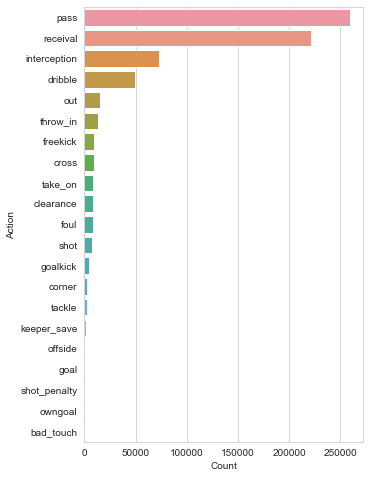

In [589]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
fig, axs = plt.subplots(figsize = (5,8))
sns.barplot(data = all_games, x = all_games.Count, y = all_games.index)
plt.ylabel('Action')

2018-03-11 17:00:00, BV Borussia 09 Dortmund - Eintracht Frankfurt : 3-2 , Michy Batshuayi Tunga 77


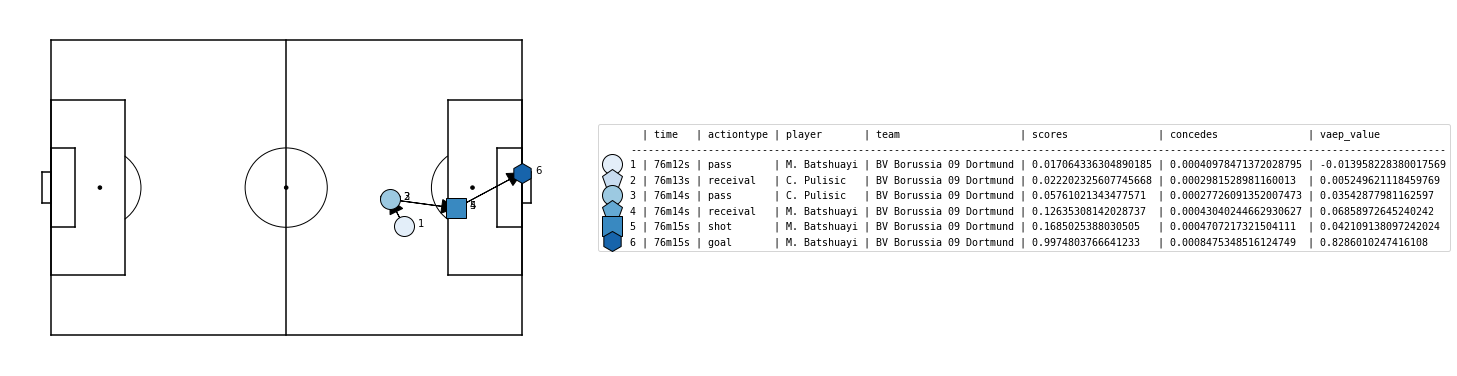

In [393]:
#For each game in the test set, append the predictions and compute vaep
B = []
actions = pd.HDFStore(spadl_h5) [f"actions/game_2516965"]
actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
)
preds = pd.HDFStore(predictions_h5) [f"game_2516965"]
values = vaepformula.value(actions, preds.scores, preds.concedes)
B.append(pd.concat([actions, preds, values], axis=1))

B = pd.concat(B).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)

#Plot
a = B.copy()
#Actions.type_name
pos = a[a.type_name == 'goal' ][1:2].action_id.values[0]
a = a[pos-5 : pos+1].copy()

a["start_x"] = a.x
a["start_y"] = a.y
a["end_x"] = a.x + a.dx
a["end_y"] = a.y + a.dy

game = games[(games.country_name == "Germany") & (games.home_team_name_short == "Borussia Dortmund") & (games.away_team_name_short == "Eintracht Frankfurt")  ]
g = game.iloc[0]
minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}"
print(game_info)

   
a["nice_time"] = a.apply(nice_time,axis=1)
labels = a[["nice_time", "type_name", "nickname", "team_name",'scores','concedes','vaep_value']]

matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    label=labels,
    labeltitle=["time", "actiontype", "player", "team",'scores','concedes','vaep_value'],
    zoom=False,
    figsize=10
)